In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from loaders import *
import math
import random
from attn_masked import parse_timeloop_stats, aggregate_timeloop_runs
import os
import json

In [5]:
opt_mapping_config = {
    "matrix_size_M_dim": 2048,
    "matrix_size_K_dim": 2048,
    "matrix_size_N_dim": 2048,
    "DRAM_factor_M": 128,
    "DRAM_factor_N": 16,
    "DRAM_factor_K": 64,
    "DRAM_permutation": [
      "K",
      "M",
      "N"
    ],
    "ClusterArray_factor_M": 2,
    "ClusterArray_factor_N": 8,
    "ClusterArray_factor_K": 1,
    "ClusterArray_permutation": [
      "N",
      "M",
      "K"
    ],
    "PE_Cluster_factor_M": 4,
    "PE_Cluster_factor_N": 1,
    "PE_Cluster_factor_K": 4,
    "PE_Cluster_permutation": [
      "K",
      "M",
      "N"
    ],
    "iact_spad_factor_M": 1,
    "iact_spad_factor_N": 1,
    "iact_spad_factor_K": 2,
    "iact_spad_permutation": [
      "K",
      "M",
      "N"
    ],
    "weight_spad_factor_M": 1,
    "weight_spad_factor_N": 1,
    "weight_spad_factor_K": 4,
    "weight_spad_permutation": [
      "K",
      "N",
      "M"
    ],
    "psum_factor_M": 2,
    "psum_factor_N": 16,
    "psum_factor_K": 1,
    "psum_permutation": [
      "K",
      "N",
      "M"
    ],
    "reg_factor_M": 1,
    "reg_factor_N": 1,
    "reg_factor_K": 1,
    "reg_permutation": [
      "N",
      "K",
      "M"
    ],
    "density_weights": 1,
    "density_inputs": 1,
    "pe_meshX": 4,
    "pe_meshY": 4
  }

In [22]:
def evaluate_config(config, sparse_opt=None):
    if sparse_opt == None:
        sparse_opt = 'designs/baseline/baseline_sparse_opt.yaml'

    out = run_timeloop_model(
        config,
        problem='designs/baseline/baseline_problem.yaml',
        mapping='designs/baseline/baseline_mapping.yaml',
        sparse_optimizations=sparse_opt, 
    )
    stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()
    return stats


def do_attention_problem(config, attributes, sparsities = [0.5, 0.001, 1.0]): 
    q1_config, q2_config, q4_config = config.copy(), config.copy(), config.copy()
    q1_config['density_inputs'] = sparsities[0]
    q2_config['density_inputs'] = sparsities[1]
    q4_config['density_inputs'] = sparsities[2]

    q1_stats = evaluate_config(q1_config)
    q2_stats = evaluate_config(q2_config)
    q4_stats = evaluate_config(q4_config)
    
    all_stats = [q1_stats, q2_stats, q1_stats, q4_stats]
    
    parsed_runs = [parse_timeloop_stats(stats) for stats in all_stats]
    combined_stats = aggregate_timeloop_runs(parsed_runs)

    curr_opt = {}
    for attr in attributes: 
        if attr in ['total_energy_uJ', 'computes_per_cycle']:
            val = combined_stats[attr]
        elif attr == 'utilization_percent': 
            val = combined_stats[attr]['overall']
        elif attr == 'memory_traffic': 
            val = sum(combined_stats[attr].values())
        else: 
            raise ValueError(f"{attr} not a valid attribute.")

        curr_opt[attr] = val
                
    return curr_opt, combined_stats

In [17]:
attributes = ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic']
opt_attr, _ = do_attention_problem(opt_mapping_config, attributes)

[INFO] 2025-05-04 23:14:53,474 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:14:56,498 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:14:59,500 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


In [18]:
opt_attr

{'total_energy_uJ': 446798.72000000003,
 'utilization_percent': 100.0,
 'computes_per_cycle': 255.99999784041145,
 'memory_traffic': 144125814898}

In [31]:
sparse_muls = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
base_sparsities = [0.5, 0.001, 1.0]

energies = []
mem_traffic = []

memory_energy_mac = []
memory_energy_reg = []
memory_energy_psum_spad = []
memory_energy_weight_spad = []
memory_energy_iact_spad = []
memory_energy_dram = []

for s_mul in sparse_muls: 
    s1, s2, s4 = base_sparsities
    sparsities = [s1 * s_mul, s2, s4 * s_mul]

    attr_map, combined_stats = do_attention_problem(opt_mapping_config, attributes, sparsities)

    memory_energy_mac.append(combined_stats["memory_energy_pJ"]['MAC'])
    memory_energy_reg.append(combined_stats["memory_energy_pJ"]['reg'])
    memory_energy_psum_spad.append(combined_stats["memory_energy_pJ"]['psum_spad'])
    memory_energy_weight_spad.append(combined_stats["memory_energy_pJ"]['weight_spad'])
    memory_energy_iact_spad.append(combined_stats["memory_energy_pJ"]['iact_spad'])
    memory_energy_dram.append(combined_stats["memory_energy_pJ"]['DRAM'])
    
    energies.append(attr_map["total_energy_uJ"])
    mem_traffic.append(attr_map["memory_traffic"])

    print(combined_stats)

energies

[INFO] 2025-05-04 23:33:56,531 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:33:59,621 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:02,682 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 181617.32, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 26890743885.89, 'reg': 38290101.94, 'psum_spad': 991643159.47, 'weight_spad': 14297379880.86, 'iact_spad': 23265321.93, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 1834487905, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 2808908611, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.6, 'reg': 22.179999999999996, 'psum_spad': 574.34, 'weight_spad': 8280.773969761833, 'iact_spad': 13.48, 'DRAM': 80723.88066658698, 'Total': 105189.25463634882}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.99991800657222, 'total_actual_computes': 1726576855, 'total_cycles': 6744443}
[INFO] 2025-05-04 23:34:05,726 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:08,898 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:11,975 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 211081.91999999998, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 53647702954.55, 'reg': 76389708.53, 'psum_spad': 1978352866.33, 'weight_spad': 15098047755.759998, 'iact_spad': 46414929.33, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 3659849005, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 3238405341, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.600000000002, 'reg': 22.179999999999996, 'psum_spad': 574.34, 'weight_spad': 4383.161018281946, 'iact_spad': 13.48, 'DRAM': 40711.970120154554, 'Total': 61279.726150905335}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.9999475300866, 'total_actual_computes': 3444563774, 'total_cycles': 13455330}
[INFO] 2025-05-04 23:34:15,065 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:18,158 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:21,232 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 240546.52000000002, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 80404661992.04999, 'reg': 114489305.85000001, 'psum_spad': 2965062338.58, 'weight_spad': 15898715392.06, 'iact_spad': 69564382.18, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 5485210106, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 3238405341, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.600000000002, 'reg': 22.18, 'psum_spad': 574.34, 'weight_spad': 3079.6315615092576, 'iact_spad': 13.480000000000002, 'DRAM': 27330.282894472806, 'Total': 46594.51445598206}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.99998269382726, 'total_actual_computes': 5162550691, 'total_cycles': 20166215}
[INFO] 2025-05-04 23:34:24,304 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:27,374 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:30,458 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 270011.12, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 107161621060.70999, 'reg': 152588913.76, 'psum_spad': 3951772045.45, 'weight_spad': 16699383266.96, 'iact_spad': 92713945.41999999, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 7310571206, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 3238405341, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.6, 'reg': 22.18, 'psum_spad': 574.34, 'weight_spad': 2427.0556411187895, 'iact_spad': 13.479999999999999, 'DRAM': 20631.088664528546, 'Total': 39242.734318131734}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.99998132239108, 'total_actual_computes': 6880537610, 'total_cycles': 26877102}
[INFO] 2025-05-04 23:34:33,541 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:36,588 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:39,725 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 299475.72, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 133918580098.20999, 'reg': 190688511.09000003, 'psum_spad': 4938481577.39, 'weight_spad': 17500050903.260002, 'iact_spad': 115863398.28999999, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 9135932309, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 3238405341, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.6, 'reg': 22.18, 'psum_spad': 574.3399999999999, 'weight_spad': 2035.2503182589583, 'iact_spad': 13.48, 'DRAM': 16608.891129579384, 'Total': 34828.731457828355}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.99999568298034, 'total_actual_computes': 8598524527, 'total_cycles': 33587987}
[INFO] 2025-05-04 23:34:42,777 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:45,868 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:48,984 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 328940.31999999995, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 160675539182.44998, 'reg': 228788113.7, 'psum_spad': 5925191192.639999, 'weight_spad': 18300718897.46, 'iact_spad': 139013016.73000002, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 10961293409, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 3238405341, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.600000000002, 'reg': 22.180000000000003, 'psum_spad': 574.34, 'weight_spad': 1773.9313643038126, 'iact_spad': 13.48, 'DRAM': 13926.311423990615, 'Total': 31884.84278829443}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.99998627753257, 'total_actual_computes': 10316511447, 'total_cycles': 40298875}
[INFO] 2025-05-04 23:34:52,061 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:55,157 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:58,243 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 358404.92, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 187432498251.11002, 'reg': 266887716.32999998, 'psum_spad': 6911900899.5, 'weight_spad': 19101386772.36, 'iact_spad': 162162579.97, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 12786654509, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 3238405341, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.600000000002, 'reg': 22.18, 'psum_spad': 574.34, 'weight_spad': 1587.2266727762442, 'iact_spad': 13.479999999999999, 'DRAM': 12009.638130283556, 'Total': 29781.45980662868}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.99998498184272, 'total_actual_computes': 12034498366, 'total_cycles': 47009762}
[INFO] 2025-05-04 23:35:01,326 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:04,499 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:07,707 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 387869.52, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 214189457288.61, 'reg': 304987318.93000007, 'psum_spad': 7898610371.77, 'weight_spad': 19902054408.66, 'iact_spad': 185312032.82, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 14612015610, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 3238405341, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.6, 'reg': 22.18, 'psum_spad': 574.34, 'weight_spad': 1447.1677505198934, 'iact_spad': 13.480000000000002, 'DRAM': 10571.831368370793, 'Total': 28203.59412201374}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.99999350342895, 'total_actual_computes': 13752485283, 'total_cycles': 53720647}
[INFO] 2025-05-04 23:35:10,830 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:13,932 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:16,971 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 417334.12, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 240946416357.27002, 'reg': 343086933.46000004, 'psum_spad': 8885320078.64, 'weight_spad': 20702722283.56, 'iact_spad': 208461596.06, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 16437376710, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 3238405341, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.599999999999, 'reg': 22.18, 'psum_spad': 574.3400000000001, 'weight_spad': 1338.216306829675, 'iact_spad': 13.480000000000002, 'DRAM': 9453.35925649381, 'Total': 26976.170566099725}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.99999169307864, 'total_actual_computes': 15470472202, 'total_cycles': 60431534}
[INFO] 2025-05-04 23:35:20,059 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:23,108 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:26,179 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


{'total_energy_uJ': 446798.72000000003, 'memory_energy_pJ': defaultdict(<class 'float'>, {'MAC': 267703375394.77, 'reg': 381186524.1700001, 'psum_spad': 9872029610.58, 'weight_spad': 21503389919.86, 'iact_spad': 231611048.93, 'DRAM': 137438953472.0}), 'memory_traffic': defaultdict(<class 'int'>, {'reg': 18262737813, 'psum_spad': 68652367872, 'weight_spad': 51539607552, 'iact_spad': 3238405341, 'DRAM': 2432696320}), 'energy_per_compute_fJ': {'MAC': 15574.6, 'reg': 22.18, 'psum_spad': 574.34, 'weight_spad': 1251.0472606768942, 'iact_spad': 13.48, 'DRAM': 8558.47077515809, 'Total': 25994.108040832485}, 'utilization_percent': {'MAC': 256.0, 'overall': 100.0}, 'computes_per_cycle': 255.99999784041145, 'total_actual_computes': 17188459119, 'total_cycles': 67142419}


[181617.32,
 211081.91999999998,
 240546.52000000002,
 270011.12,
 299475.72,
 328940.31999999995,
 358404.92,
 387869.52,
 417334.12,
 446798.72000000003]

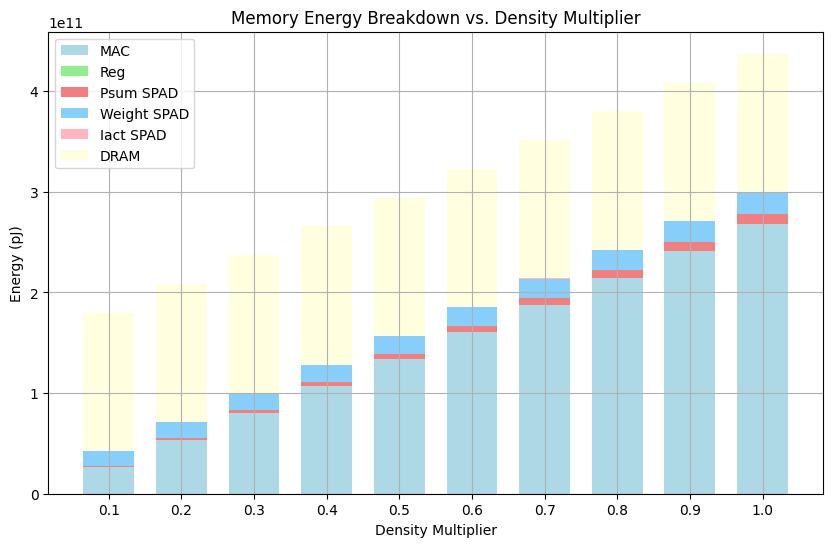

In [28]:
# Convert all energy lists to a 2D numpy array for easier plotting
energy_data = np.array([memory_energy_mac, memory_energy_reg, memory_energy_psum_spad, memory_energy_weight_spad, memory_energy_iact_spad, memory_energy_dram])

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Adjusting the x positions to add space between bars
x_pos = np.arange(len(sparse_muls))

# Bar width to allow space between bars
bar_width = 0.7

# Create the stacked bar chart with adjusted x positions
ax.bar(x_pos, energy_data[0], width=bar_width, label='MAC', color='lightblue')
ax.bar(x_pos, energy_data[1], bottom=energy_data[0], width=bar_width, label='Reg', color='lightgreen')
ax.bar(x_pos, energy_data[2], bottom=energy_data[0] + energy_data[1], width=bar_width, label='Psum SPAD', color='lightcoral')
ax.bar(x_pos, energy_data[3], bottom=energy_data[0] + energy_data[1] + energy_data[2], width=bar_width, label='Weight SPAD', color='lightskyblue')
ax.bar(x_pos, energy_data[4], bottom=energy_data[0] + energy_data[1] + energy_data[2] + energy_data[3], width=bar_width, label='Iact SPAD', color='lightpink')
ax.bar(x_pos, energy_data[5], bottom=energy_data[0] + energy_data[1] + energy_data[2] + energy_data[3] + energy_data[4], width=bar_width, label='DRAM', color='lightyellow')

# Adding labels and title
ax.set_xlabel("Density Multiplier")
ax.set_ylabel("Energy (pJ)")
ax.set_title("Memory Energy Breakdown vs. Density Multiplier")

# Set x-ticks to match sparse_muls
ax.set_xticks(x_pos)
ax.set_xticklabels(sparse_muls)

# Adding the legend
ax.legend()

# Show the plot
plt.grid(True)
plt.show()

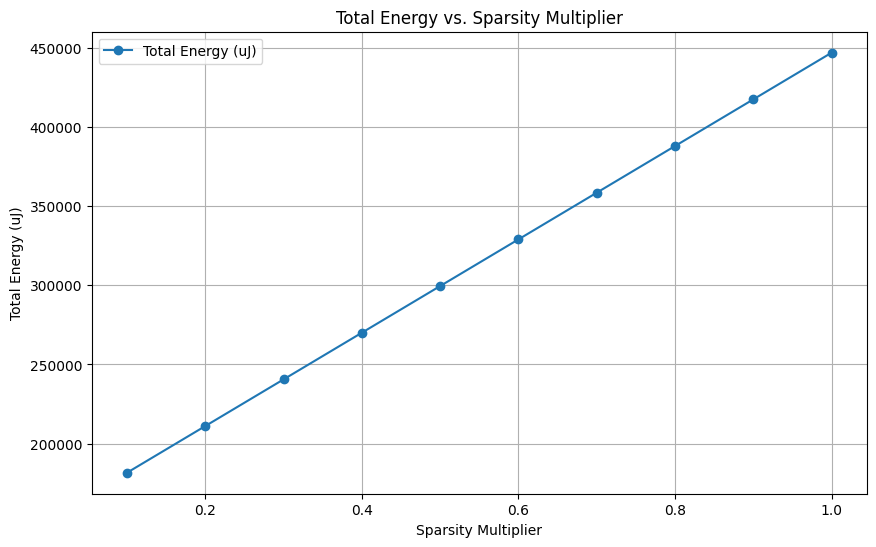

In [29]:
sparse_muls_np = np.array(sparse_muls)

plt.figure(figsize=(10, 6))
plt.plot(sparse_muls_np, energies, label="Total Energy (uJ)", marker='o')
plt.xlabel("Sparsity Multiplier")
plt.ylabel("Total Energy (uJ)")
plt.title("Total Energy vs. Sparsity Multiplier")
plt.grid(True)
plt.legend()
plt.show()

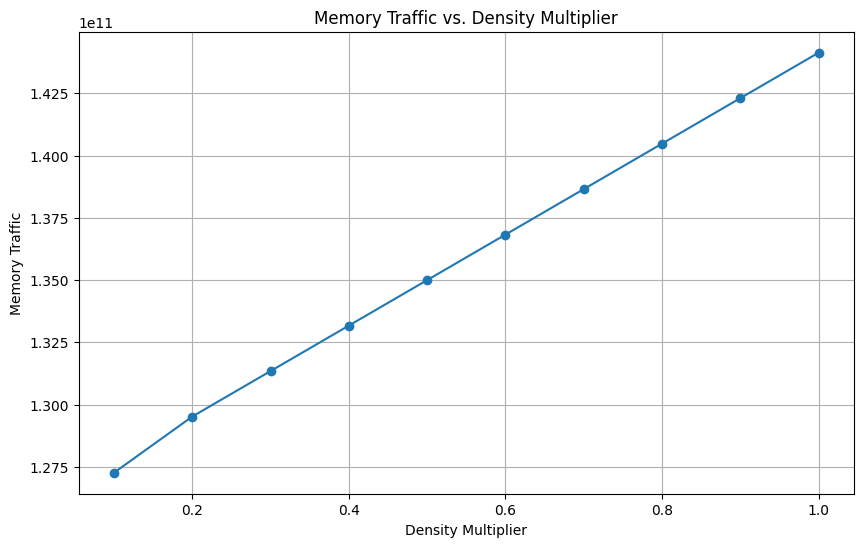

In [33]:
sparse_muls_np = np.array(sparse_muls)

plt.figure(figsize=(10, 6))
plt.plot(sparse_muls_np, mem_traffic, marker='o')
plt.xlabel("Density Multiplier")
plt.ylabel("Memory Traffic")
plt.title("Memory Traffic vs. Density Multiplier")
plt.grid(True)
plt.show()